In [1]:
import os
import trompy as tp
import numpy as np
import matplotlib.pyplot as plt


%run "..//src//vgp_helper_fx"

In [2]:
ROOT_FOLDER = "D:\\VGP"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "2P\\proc_s2p\\")
BEHAV_FOLDER = os.path.join(ROOT_FOLDER, "Bonsai\\")
METAFILE = os.path.join(ROOT_FOLDER, "Metafile_VGP2.4.xls")
rows, header = tp.metafilereader(METAFILE, sheetname="Analysis_Cas+malt")


File is excel file. Making csv metafile first


In [3]:
# Goes through metafile assembling data from s2p files where possible

cell_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[3]
        animal=row[0]
        day=row[2]
        date=int(row[1])
        events=row[6]
#         solution=row[3]
        
        s2p_folder = os.path.join(DATA_FOLDER,
                                  "sub-{}\\ses-{}-{}\\suite2p\\plane0"
                                  .format(animal, day, date))
        events_file =BEHAV_FOLDER+events
        
        
        cell_data[key] = assemble_data(s2p_folder,events_file)
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet'] = row[11]
        cell_data[key]['session'] = row[3]
        cell_data[key]['solution']=row[5]
        
    except FileNotFoundError:
        print('Cannot find file for', key)
     

Cannot find file for VGP306_M5
Cannot find file for VGP307_C3
Cannot find file for VGP402_C1


In [4]:
cell_data['VGP118_C1'].keys()

dict_keys(['animal', 'diet', 'solution', 'raw_F', 'neu_F', 'iscell', 'pump_snips_all', 'pump_responsive', 'lick_snips_all', 'lick_responsive', 'df_responsive', 'session'])

In [5]:
PR_C1_licks_act=[]
PR_C1_licks_nonres=[]

PR_C2_licks_act=[]
PR_C2_licks_nonres=[]

PR_C3_licks_act=[]
PR_C3_licks_nonres=[]

animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='PR' and d['session']=='C1':
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_C1_licks_act.append(np.mean(lick_snips, axis=0))
#         snips_non=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==0)],axis=1)) 
#         PR_C1_licks_nonres.append(np.mean(snips_non, axis=0))
        
    elif d['diet']=='PR' and d['session']=='C2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_C2_licks_act.append(np.mean(lick_snips, axis=0))
#         snips_non=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==0)],axis=1)) 
#         PR_C2_licks_nonres.append(np.mean(snips_non, axis=0))
    
    elif d['diet']=='PR' and d['session']=='C3':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_C3_licks_act.append(np.mean(lick_snips, axis=0))
#         snips_non=(np.mean(d['lick_snips_all'][np.where(d['lick_responsive']==0)],axis=1)) 
#         PR_C3_licks_nonres.append(np.mean(snips_non, axis=0))

#Filtering out empty arrays        
PR_C2_licks_act_f=[]        
for animal in PR_C2_licks_act: 
    if not np.isnan(animal).any(): 
        PR_C2_licks_act_f.append(animal)

C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [6]:
PR_M1_licks_act=[]
PR_M2_licks_act=[]
PR_M3_licks_act=[]


animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='PR' and d['session']=='M1':
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_M1_licks_act.append(np.mean(lick_snips, axis=0))
        
    elif d['diet']=='PR' and d['session']=='M2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_M2_licks_act.append(np.mean(lick_snips, axis=0))       
    
    elif d['diet']=='PR' and d['session']=='M3':
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        PR_M3_licks_act.append(np.mean(lick_snips, axis=0))
        
print(animal)
PR_M2_licks_act_f=[]        
for animal in PR_M2_licks_act: 
    if not np.isnan(animal).any(): 
        PR_M2_licks_act_f.append(animal)

['VGP118', 'VGP203', 'VGP302', 'VGP306', 'VGP307', 'VGP402', 'VGP505', 'VGP506', 'VGP509']


In [7]:
NR_C1_licks_act=[]
NR_C2_licks_act=[]
NR_C3_licks_act=[]

animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='NR' and d['session']=='C1':
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_C1_licks_act.append(np.mean(lick_snips, axis=0))

        
    elif d['diet']=='NR' and d['session']=='C2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_C2_licks_act.append(np.mean(lick_snips, axis=0))

    
    elif d['diet']=='NR' and d['session']=='C3':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_C3_licks_act.append(np.mean(lick_snips, axis=0))




NR_C3_licks_act_f=[]        
for animal in NR_C3_licks_act: 
    if not np.isnan(animal).any(): 
        NR_C3_licks_act_f.append(animal)


In [8]:
NR_M1_licks_act=[]
NR_M2_licks_act=[]
NR_M3_licks_act=[]


animal=[]

for key in cell_data.keys():
    d=cell_data[key]
    if d['diet']=='NR' and d['session']=='M1':
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_M1_licks_act.append(np.mean(lick_snips, axis=0))
        
    elif d['diet']=='NR' and d['session']=='M2':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_M2_licks_act.append(np.mean(lick_snips, axis=0))

    elif d['diet']=='NR' and d['session']=='M3':
        animal.append(d['animal'])
        lick_snips=(np.mean(d['pump_snips_all'][np.where(d['lick_responsive']==1)],axis=1)) 
        NR_M3_licks_act.append(np.mean(lick_snips, axis=0))



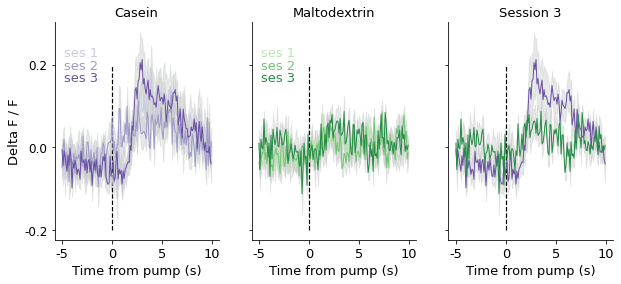

In [9]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)

tp.shadedError(ax[0], PR_C1_licks_act, linecolor="#cbc9e2")

tp.shadedError(ax[0], PR_C2_licks_act_f, linecolor="#9e9ac8")

tp.shadedError(ax[0], PR_C3_licks_act, linecolor="#6a51a3")



tp.shadedError(ax[1], PR_M1_licks_act, linecolor="#bae4b3")

tp.shadedError(ax[1], PR_M2_licks_act_f, linecolor="#74c476")

tp.shadedError(ax[1], PR_M3_licks_act, linecolor="#238b45")


tp.shadedError(ax[2], PR_C3_licks_act, linecolor="#6a51a3")
tp.shadedError(ax[2], PR_M3_licks_act, linecolor="#238b45")


ax[0].text(2, 0.22, "ses 1",color='#cbc9e2', size=13)
ax[0].text(2, 0.19, "ses 2", color="#9e9ac8",size=13)
ax[0].text(2, 0.16, "ses 3", color="#6a51a3",size=13)

ax[1].text(2, 0.22, "ses 1",color='#bae4b3', size=13)
ax[1].text(2, 0.19, "ses 2", color="#74c476",size=13)
ax[1].text(2, 0.16, "ses 3", color="#238b45",size=13)


for axis in ax:
    axis.set_xticks([0,50,100,150])
    axis.set_xticklabels(["-5", "0", "5", "10"],rotation=0, size=13)
    axis.set_yticks([-0.2, 0.0, 0.2])
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.vlines([50],-0.2,0.2, color="black", linestyle="--", linewidth=1.2)
    axis.set_xlabel("Time from pump (s)", size=13)


ax[0].set_ylabel("Delta F / F", size=13)
ax[0].set_yticklabels([-0.2, 0.0, 0.2], size=12)

ax[0].set_title('Casein', size=13)
ax[1].set_title('Maltodextrin', size=13)
ax[2].set_title('Session 3', size=13)


f.savefig("..//output//PR_licksnips_casmalt.pdf")


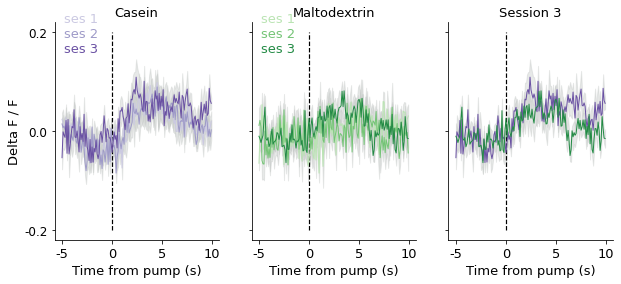

In [10]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)

tp.shadedError(ax[0], NR_C1_licks_act, linecolor="#cbc9e2")

tp.shadedError(ax[0], NR_C2_licks_act, linecolor="#9e9ac8")

tp.shadedError(ax[0], NR_C3_licks_act_f, linecolor="#6a51a3")



tp.shadedError(ax[1], NR_M1_licks_act, linecolor="#bae4b3")

tp.shadedError(ax[1], NR_M2_licks_act, linecolor="#74c476")

tp.shadedError(ax[1], NR_M3_licks_act, linecolor="#238b45")


tp.shadedError(ax[2], NR_C3_licks_act_f, linecolor="#6a51a3")
tp.shadedError(ax[2], NR_M3_licks_act, linecolor="#238b45")



ax[0].text(2, 0.22, "ses 1",color='#cbc9e2', size=13)
ax[0].text(2, 0.19, "ses 2", color="#9e9ac8",size=13)
ax[0].text(2, 0.16, "ses 3", color="#6a51a3",size=13)

ax[1].text(2, 0.22, "ses 1",color='#bae4b3', size=13)
ax[1].text(2, 0.19, "ses 2", color="#74c476",size=13)
ax[1].text(2, 0.16, "ses 3", color="#238b45",size=13)


for axis in ax:
    axis.set_xticks([0,50,100,150])
    axis.set_xticklabels(["-5", "0", "5", "10"],rotation=0, size=13)
    axis.set_yticks([-0.2, 0.0, 0.2])
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.vlines([50],-0.2,0.2, color="black", linestyle="--", linewidth=1.2)
    axis.set_xlabel("Time from pump (s)", size=13)


ax[0].set_ylabel("Delta F / F", size=13)
ax[0].set_yticklabels([-0.2, 0.0, 0.2], size=12)

ax[0].set_title('Casein', size=13)
ax[1].set_title('Maltodextrin', size=13)
ax[2].set_title('Session 3', size=13)


f.savefig("..//output//NR_licksnips_casmalt.pdf")

In [11]:
cell_data['VGP118_C1']['df_responsive']

,responsive,activated,inhibited
pump_all,3,0,3
lick_all,7,5,2
pump_only,2,0,3
lick_only,6,5,2
both,1,0,0
neither,6,10,10


In [36]:
cols = ["animal", "diet", "session","solution", "lick_activated"]
df_activated = pd.DataFrame(columns=cols)

for key, d in cell_data.items():
    percent_act = d["df_responsive"].loc["lick_all", "activated"] / np.sum(d["df_responsive"].loc['pump_only':'neither',"activated"]) * 100
    data = np.array([d["animal"], d["diet"], d["session"], d["solution"],percent_act])
    df_temp = pd.DataFrame({col: value for col, value in zip(cols, data)},
                          index=[key.split("_")[0]]).astype({'lick_activated':'float'})
    

    df_activated = pd.concat([df_activated, df_temp])
    
    


df_activated

,animal,diet,session,solution,lick_activated
VGP118,VGP118,PR,C1,Cas,33.333333
VGP118,VGP118,PR,C2,Cas,15.384615
VGP118,VGP118,PR,M1,Malt,18.750000
VGP118,VGP118,PR,M2,Malt,35.000000
VGP118,VGP118,PR,M3,Malt,26.315789
...,...,...,...,...,...
VGP509,VGP509,PR,C1,Cas,15.151515
VGP509,VGP509,PR,M2,Malt,19.444444
VGP509,VGP509,PR,C2,Cas,31.034483
VGP509,VGP509,PR,C3,Cas,28.125000


In [32]:
df_pref = (df_activated.pivot_table(index=["animal", "diet"],
                         columns=["solution"],
                         values="lick_activated",
                         aggfunc="mean")
             .astype({"Cas": "float", "Malt": "float"})
#              .assign(pref=lambda df_: df_.cas / (df_.cas + df_.malt))
             .assign(pref=lambda df_: df_.Cas - df_.Malt)
            )


In [33]:
df_session = (df_activated.pivot_table(index=["animal", "diet"],
                         columns=["session"],
                         values="lick_activated",
#                          aggfunc="mean"
                                 )
             .astype({"C1": "float", 'C2':"float","C3":"float","M1": "float","M2":"float", "M3":"float"})
#              .assign(pref=lambda df_: df_.cas / (df_.cas + df_.malt))
        )

df_session

session             C1         C2         C3         C4         C5         C6  \
animal diet                                                                     
VGP118 PR    33.333333  15.384615        NaN        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  31.578947  33.333333  27.777778   
VGP202 NR    41.860465  46.153846  15.000000        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  25.862069  21.428571  19.047619   
VGP203 PR    15.151515   7.407407  33.333333        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  17.741935  30.000000  12.195122   
VGP204 NR    11.111111  18.750000  10.526316        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  12.500000   0.000000   9.090909   
VGP302 PR    57.000000  56.716418  62.318841        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  48.051948  40.000000        NaN   
VGP306 PR    22.222222   0.000000  29.411765        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN   4.347826   0.000000        NaN   
VGP307 PR    25.000000  10.714286        NaN        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  16.666667   0.000000        NaN   
VGP310 NR    15.384615  10.416667  35.135135        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  24.000000  22.500000        NaN   
VGP402 PR          NaN   0.000000   4.545455        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN   6.976744  23.333333   8.823529   
VGP403 NR    33.333333  17.142857  33.333333        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN   5.128205   7.317073  34.883721   
VGP404 NR    12.500000  16.000000   0.000000        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  21.621622   5.263158  10.526316   
VGP501 NR    26.086957  26.190476  21.052632        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  44.444444  39.393939  51.515152   
VGP502 NR    22.222222  16.666667   0.000000        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  29.545455   5.882353   4.761905   
VGP503 NR    21.052632  28.125000  24.324324        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  14.285714   0.000000  18.750000   
VGP504 NR    29.090909  32.608696  23.404255        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  38.297872  41.025641  20.833333   
VGP505 PR    42.592593  10.638298  61.538462        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  52.380952  21.052632  35.897436   
VGP506 PR    12.500000  33.333333  52.631579        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  10.714286  30.769231   0.000000   
VGP509 PR    15.151515  31.034483  28.125000        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  53.658537  26.923077   4.347826   

session             M1         M2         M3         M4         M5         M6  
animal diet                                                                    
VGP118 PR    18.750000  35.000000  26.315789        NaN        NaN        NaN  
       PRNR        NaN        NaN        NaN  11.764706  30.769231  27.777778  
VGP202 NR    11.111111  26.470588  30.303030        NaN        NaN        NaN  
       NRPR        NaN        NaN        NaN   5.172414  20.588235  25.000000  
VGP203 PR    22.222222  26.829268  22.222222        NaN        NaN        NaN  
       PRNR        NaN        NaN        NaN  18.181818  31.250000  21.428571  
VGP204 NR    15.789474  22.222222        NaN        NaN        NaN        NaN  
       NRPR        NaN        NaN        NaN  16.000000  22.580645  10.714286  
VGP302 PR    24.000000  50.602410  49.206349        NaN        NaN        NaN  
       PRNR        NaN        NaN        

In [34]:
# PRs = ["PR"]
# NRs = ["NR"]

# (df_pref
#  .droplevel(0)
#  .pref
#  .reset_index()
#  .query("diet in @PRs")
#  .mean()
# #  .loc["PR"]
# )



In [35]:
df_pref

solution           Cas       Malt       pref
animal diet                                 
VGP118 PR    24.358974  26.688596  -2.329622
       PRNR  30.896686  23.437238   7.459448
VGP202 NR    34.338104  22.628243  11.709861
       NRPR  22.112753  16.920216   5.192537
VGP203 PR    18.630752  23.757904  -5.127152
       PRNR  19.979019  23.620130  -3.641111
VGP204 NR    13.462476  19.005848  -5.543372
       NRPR   7.196970  16.431644  -9.234674
VGP302 PR    58.678419  41.269586  17.408833
       PRNR  44.025974  20.700848  23.325126
VGP306 PR    17.211329  16.167945   1.043384
       PRNR   2.173913  28.571429 -26.397516
VGP307 PR    17.857143  18.459962  -0.602819
       PRNR   8.333333  17.045455  -8.712121
VGP310 NR    20.312139  36.539708 -16.227569
       NRPR  23.250000  11.805556  11.444444
VGP402 PR     2.272727   4.482759  -2.210031
       PRNR  13.044536  10.220865   2.823671
VGP403 NR    27.936508  21.233766   6.702742
       NRPR  15.776333  20.168350  -4.392017
VGP404 NR     9.500000   7.207265   2.292735
       NRPR  12.470365  13.709677  -1.239312
VGP501 NR    24.443355  24.922601  -0.479246
       NRPR  45.117845  22.558721  22.559124
VGP502 NR    12.962963  11.980177   0.982786
       NRPR  13.396571   3.277962  10.118608
VGP503 NR    24.500652  18.972521   5.528131
       NRPR  11.011905   7.382479   3.629426
VGP504 NR    28.367953  18.181941  10.186012
       NRPR  33.385616  24.125874   9.259741
VGP505 PR    38.256451  25.333185  12.923266
       PRNR  36.443673  20.524691  15.918982
VGP506 PR    32.821637  16.218102  16.603535
       PRNR  13.827839  13.857630  -0.029791
VGP509 PR    24.770333  23.600637   1.169696
       PRNR  28.309813  15.660955  12.648858

In [17]:
df_session

session             C1         C2         C3         C4         C5         C6  \
animal diet                                                                     
VGP118 PR    33.333333  15.384615        NaN        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  31.578947  33.333333  27.777778   
VGP202 NR    41.860465  46.153846  15.000000        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  25.862069  21.428571  19.047619   
VGP203 PR    15.151515   7.407407  33.333333        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  17.741935  30.000000  12.195122   
VGP204 NR    11.111111  18.750000  10.526316        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  12.500000   0.000000   9.090909   
VGP302 PR    57.000000  56.716418  62.318841        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  48.051948  40.000000        NaN   
VGP306 PR    22.222222   0.000000  29.411765        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN   4.347826   0.000000        NaN   
VGP307 PR    25.000000  10.714286        NaN        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  16.666667   0.000000        NaN   
VGP310 NR    15.384615  10.416667  35.135135        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  24.000000  22.500000        NaN   
VGP402 PR          NaN   0.000000   4.545455        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN   6.976744  23.333333   8.823529   
VGP403 NR    33.333333  17.142857  33.333333        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN   5.128205   7.317073  34.883721   
VGP404 NR    12.500000  16.000000   0.000000        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  21.621622   5.263158  10.526316   
VGP501 NR    26.086957  26.190476  21.052632        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  44.444444  39.393939  51.515152   
VGP502 NR    22.222222  16.666667   0.000000        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  29.545455   5.882353   4.761905   
VGP503 NR    21.052632  28.125000  24.324324        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  14.285714   0.000000  18.750000   
VGP504 NR    29.090909  32.608696  23.404255        NaN        NaN        NaN   
       NRPR        NaN        NaN        NaN  38.297872  41.025641  20.833333   
VGP505 PR    42.592593  10.638298  61.538462        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  52.380952  21.052632  35.897436   
VGP506 PR    12.500000  33.333333  52.631579        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  10.714286  30.769231   0.000000   
VGP509 PR    15.151515  31.034483  28.125000        NaN        NaN        NaN   
       PRNR        NaN        NaN        NaN  53.658537  26.923077   4.347826   

session             M1         M2         M3         M4         M5         M6  
animal diet                                                                    
VGP118 PR    18.750000  35.000000  26.315789        NaN        NaN        NaN  
       PRNR        NaN        NaN        NaN  11.764706  30.769231  27.777778  
VGP202 NR    11.111111  26.470588  30.303030        NaN        NaN        NaN  
       NRPR        NaN        NaN        NaN   5.172414  20.588235  25.000000  
VGP203 PR    22.222222  26.829268  22.222222        NaN        NaN        NaN  
       PRNR        NaN        NaN        NaN  18.181818  31.250000  21.428571  
VGP204 NR    15.789474  22.222222        NaN        NaN        NaN        NaN  
       NRPR        NaN        NaN        NaN  16.000000  22.580645  10.714286  
VGP302 PR    24.000000  50.602410  49.206349        NaN        NaN        NaN  
       PRNR        NaN        NaN        

Dataframes for each group (NR and PR) Casein and maltodextrin activated cells

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making dataframe for NR-NRPR group
df_NR_cas = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Cas")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

df_NR_malt = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Malt")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

# Making dataframe for PR-PRNR group
df_PR_cas = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Cas")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)

df_PR_malt = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Malt")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)


print(df_NR_malt)
print(df_NR_cas)
print(df_PR_malt)
print(df_PR_cas)



diet           NR       NRPR
animal                      
VGP202  22.628243  16.920216
VGP204  19.005848  16.431644
VGP310  36.539708  11.805556
VGP403  21.233766  20.168350
VGP404   7.207265  13.709677
VGP501  24.922601  22.558721
VGP502  11.980177   3.277962
VGP503  18.972521   7.382479
VGP504  18.181941  24.125874
diet           NR       NRPR
animal                      
VGP202  34.338104  22.112753
VGP204  13.462476   7.196970
VGP310  20.312139  23.250000
VGP403  27.936508  15.776333
VGP404   9.500000  12.470365
VGP501  24.443355  45.117845
VGP502  12.962963  13.396571
VGP503  24.500652  11.011905
VGP504  28.367953  33.385616
diet           PR       PRNR
animal                      
VGP118  26.688596  23.437238
VGP203  23.757904  23.620130
VGP302  41.269586  20.700848
VGP306  16.167945  28.571429
VGP307  18.459962  17.045455
VGP402   4.482759  10.220865
VGP505  25.333185  20.524691
VGP506  16.218102  13.857630
VGP509  23.600637  15.660955
diet           PR       PRNR
animal        

Figure for cells activated by casein and maltodextrin

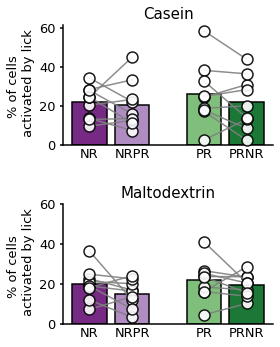

In [19]:
NR_cas=[]
NRPR_cas=[]
for row in df_NR_cas.iterrows():
    NR_cas.append(row[1].NR)
    NRPR_cas.append(row[1].NRPR)

NR_malt=[]
NRPR_malt=[]
for row in df_NR_malt.iterrows():
    NR_malt.append(row[1].NR)
    NRPR_malt.append(row[1].NRPR)
    
    
PR_cas=[]
PRNR_cas=[]
for row in df_PR_cas.iterrows():
    PR_cas.append(row[1].PR)
    PRNR_cas.append(row[1].PRNR)

PR_malt=[]
PRNR_malt=[]
for row in df_PR_malt.iterrows():
    PR_malt.append(row[1].PR)
    PRNR_malt.append(row[1].PRNR)

    

colors_1=['#762a83', '#af8dc3','#7fbf7b','#1b7837']


f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.5, bottom=0.05, left=0.25)

tp.barscatter([[NR_cas,NRPR_cas],[PR_cas,PRNR_cas]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR', 'PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              show_legend=False)

tp.barscatter([[NR_malt,NRPR_malt],[PR_malt,PRNR_malt]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR', 'PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              show_legend=False)

ax[0].set_ylabel('% of cells \n activated by lick',fontsize = 13)
ax[0].set_yticks([0,20,40,60])
ax[0].set_yticklabels([0,20,40,60], fontsize = 13)

ax[1].set_ylabel('% of cells \n activated by lick',fontsize = 13)
ax[1].set_yticks([0,20,40,60])
ax[1].set_yticklabels([0,20,40,60], fontsize = 13)


ax[0].set_title('Casein', fontsize =15)
ax[1].set_title('Maltodextrin', fontsize =15)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\%_lick_activated_cells.png')

Dataframes for each group (NR and PR) Preferense

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making dataframe for NR-NRPR group
df_NR = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

# Making dataframe for PR-PRNR group
df_PR = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)

# print(df_NR)
# print(df_PR)





Figure for proportion of cells activated by casin - malodextrin

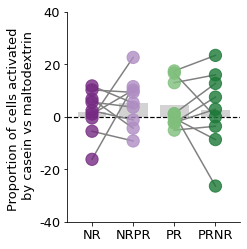

In [21]:
f, ax = plt.subplots(figsize=(4,4))
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)


x1 = [1,2]
x2=[3,4]
for row in df_NR.iterrows():
    y = [row[1].NR,row[1].NRPR]
#     print(y)
    ax.plot(x1, y, color="grey")
    ax.scatter(x1, y, s=150, color=["#762a83", "#af8dc3"], zorder=20, alpha=0.8)

for row in df_PR.iterrows():
    y = [row[1].PR,row[1].PRNR]
#     print(y)
    ax.plot(x2, y, color="grey")
    ax.scatter(x2, y, s=150, color=["#7fbf7b", "#1b7837"], zorder=20, alpha=0.8)

  
    
ax.bar(x1, [df_NR.NR.mean(), df_NR.NRPR.mean()], width=0.7, zorder=-1, color="lightgrey")
ax.bar(x2, [df_PR.PR.mean(), df_PR.PRNR.mean()], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Proportion of cells activated \n by casein vs maltodextrin", size=13)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels(['-40','-20','0','20','40'], size=13)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["NR", 'NRPR','PR','PRNR'], size=13)
ax.set_xlim([0.4,4.6])

ax.axhline(0, color="k", linestyle="--", zorder=-1,lw=1.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\pref_casein_cells.png')

In [22]:
df_diet1 = (df_pref
#  .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_: df_.PR,
         PRNR=lambda df_:df_.PRNR,
         NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR,
)
 .drop(columns=["NRPR", "PRNR"])
)



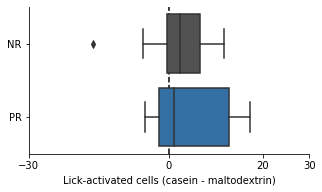

In [23]:
my_colors = {'NR': '#525252', 'PR': '#2171b5'}

'','','',''
f, ax = plt.subplots(figsize=(6,3),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})

sns.boxplot(data=df_diet1,orient="h", ax=ax, palette=my_colors)


ax.set_ylabel("")
ax.set_yticklabels(["NR", "PR"])
ax.set_xticks([-30, 0, 20, 30])
ax.set_xlabel("Lick-activated cells (casein - maltodextrin)")

ax.axvline(0, color="k", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [24]:
df_boxplot = (df_pref
#  .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_: df_.PR,
         PRNR=lambda df_:df_.PRNR,
         NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR,
)
#  .drop(columns=["NRPR", "PRNR"])
)





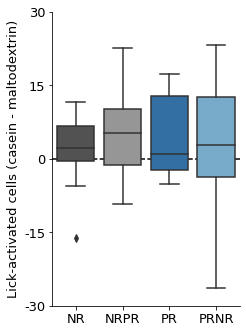

In [25]:
my_colors = {'NR': '#525252', 'NRPR': '#969696', 'PR': '#2171b5','PRNR':'#6baed6'}

'','','',''
f, ax = plt.subplots(figsize=(4,6),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})


sns.boxplot(data=df_boxplot,orient="v", ax=ax, palette=my_colors)


ax.set_xlabel("")
ax.set_xticklabels(["NR",'NRPR', "PR", 'PRNR'],size=13)
ax.set_yticks([-30, -15,0, 15, 30])
ax.set_yticklabels(['-30','-15', '0', '15', '30'],size=13)
ax.set_ylabel("Lick-activated cells (casein - maltodextrin)",size=13)

ax.axhline(0, color="k", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [26]:
sns.boxplot?

Signature:
sns.boxplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A 